## Import TensorFlow and other libraries

In [1]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display
from glob import glob
import numpy as np

from datetime import datetime

## Load the dataset

You can download this dataset and similar datasets from [here](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). As mentioned in the [paper](https://arxiv.org/abs/1611.07004), apply random jittering and mirroring to the training dataset.

* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [2]:
path_train = "/glade/scratch/hgamarro/Deep_learning/Final_Project/data/interim/Vegas_v1/train/"
path_val = "/glade/scratch/hgamarro/Deep_learning/Final_Project/data/interim/Vegas_v1/train/"

In [3]:
BUFFER_SIZE = 400
BATCH_SIZE = 32
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [4]:
def load_data(path):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    return images, masks


def load_image_mask(image_file,mask_file):
    input_image = tf.io.read_file(image_file)
    input_image = tf.image.decode_png(input_image)
    
    mask_image = tf.io.read_file(mask_file)
    mask_image = tf.image.decode_png(mask_image)


    input_image = tf.cast(input_image, tf.float32)
    mask_image = tf.cast(mask_image, tf.float32)

    return input_image, mask_image

def resize(input_image, mask_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask_image = tf.image.resize(mask_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, mask_image

def normalize(input_image, mask_image):
    input_image = (input_image / 255)
    mask_image = (mask_image / 1) 

    return input_image, mask_image



In [5]:
def load_image_train(image_file,mask_file):
    input_image, mask_image = load_image_mask(image_file,mask_file)
    input_image, mask_image = resize(input_image, mask_image,
                                   IMG_WIDTH, IMG_HEIGHT)
    input_image, mask_image = normalize(input_image, mask_image)
    return input_image, mask_image

In [6]:
def load_image_test(image_file,mask_file):
    input_image, mask_image = load_image_mask(image_file,mask_file)
    input_image, mask_image = resize(input_image, mask_image,
                                   IMG_WIDTH, IMG_HEIGHT)
    input_image, mask_image = normalize(input_image, mask_image)
    return input_image, mask_image

## Input Pipeline

In [7]:
train_images_list, train_masks_list = load_data(path_train)
print(f"Images: {len(train_images_list)} - Masks: {len(train_masks_list)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_images_list, train_masks_list))
train_dataset = train_dataset.map(load_image_test)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

Images: 2303 - Masks: 2303


In [8]:
val_images_list, val_masks_list = load_data(path_train)
print(f"Images: {len(val_images_list)} - Masks: {len(val_masks_list)}")

test_dataset = tf.data.Dataset.from_tensor_slices((val_images_list, val_masks_list))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

Images: 2303 - Masks: 2303


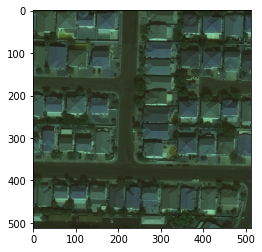

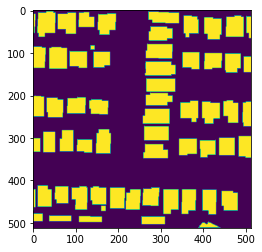

In [9]:
inp, re = load_image_train(train_images_list[100], train_masks_list[100])
# casting to int for matplotlib to show the image
plt.figure()
plt.imshow(inp)
plt.figure()
plt.imshow(re)

## Build the Generator
  * The architecture of generator is a modified U-Net.
  * Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
  * Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
  * There are skip connections between the encoder and decoder (as in U-Net).


In [10]:
OUTPUT_CHANNELS = 1

In [11]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

        result.add(tf.keras.layers.LeakyReLU())

    return result

In [12]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 256, 256, 3)


In [13]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [14]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 512, 512, 3)


In [15]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])

    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        #downsample(64, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        #upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)
        

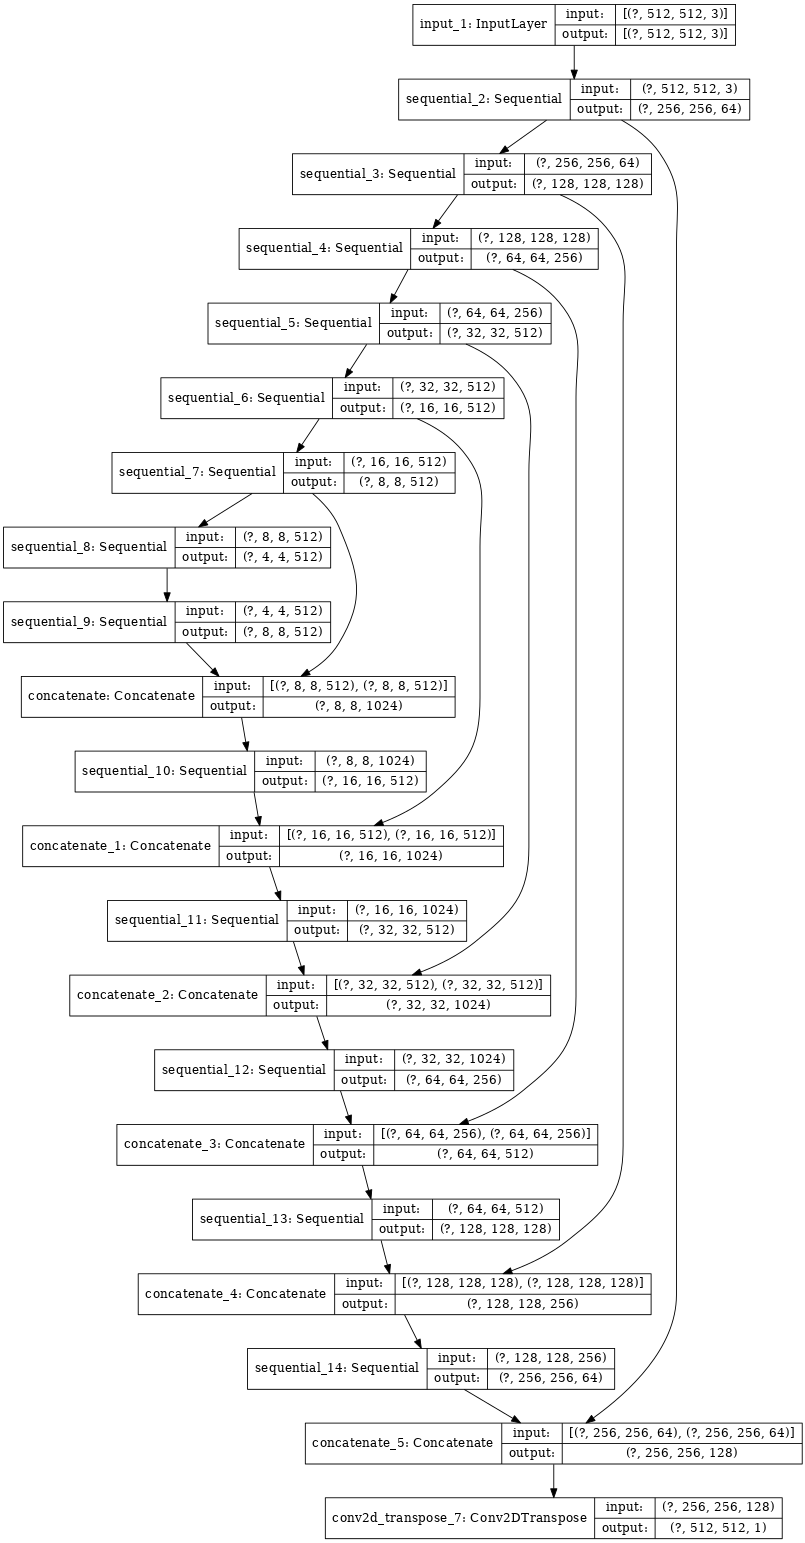

In [16]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

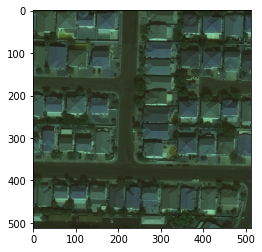

In [17]:
plt.imshow(inp)

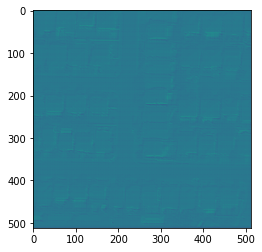

In [18]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).

The training procedure for the generator is shown below:

In [19]:
LAMBDA = 100

In [20]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

![Generator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * Concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
    tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
    down4 = downsample(512, 4)(down3)  # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512*2, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)
        

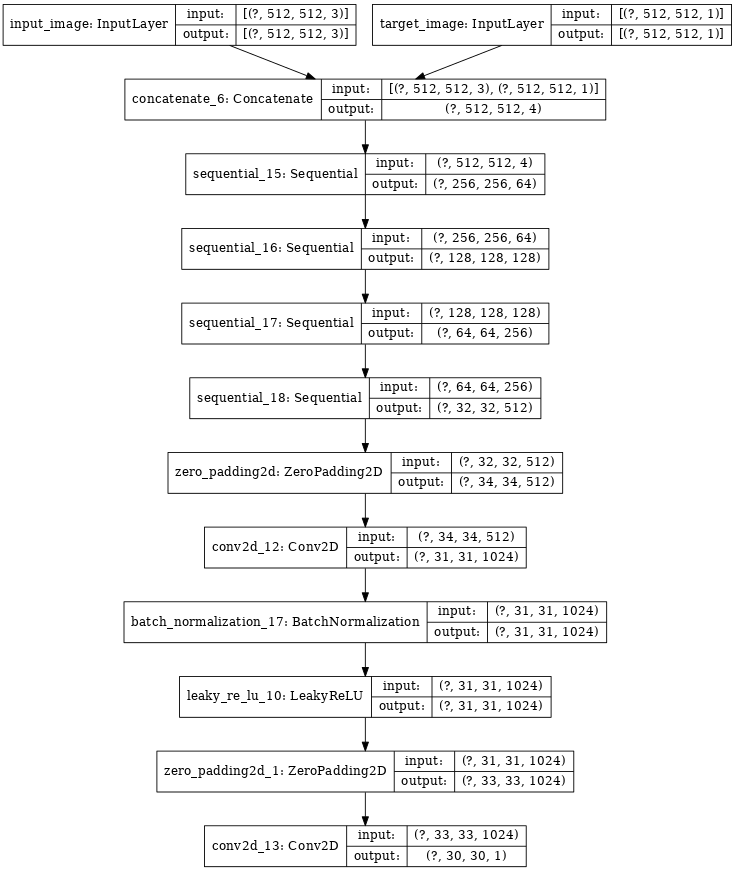

In [23]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [24]:
# def Discriminator():
#     initializer = tf.random_normal_initializer(0., 0.02)

#     inp = tf.keras.layers.Input(shape=(512, 512, 3), name='input_image')
#     tar = tf.keras.layers.Input(shape=(512, 512, 1), name='target_image')

#     x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

#     down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
#     down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
#     down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)
#     down4 = downsample(512, 4)(down2)  # (bs, 32, 32, 256)

#     zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)  # (bs, 34, 34, 256)
#     conv = tf.keras.layers.Conv2D(512, 4, strides=1,
#                                 kernel_initializer=initializer,
#                                 use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

#     batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

#     leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

#     zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

#     last = tf.keras.layers.Conv2D(1, 4, strides=1,
#                                 kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

#     with mirrored_strategy.scope():
#         return tf.keras.Model(inputs=[inp, tar], outputs=last)

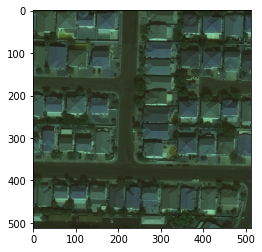

In [25]:
plt.imshow(inp)

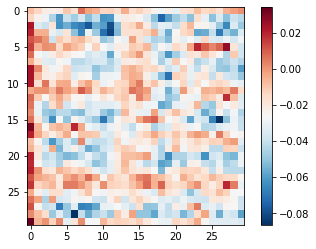

In [26]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss


In [27]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

The training procedure for the discriminator is shown below.

To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


## Define the Optimizers and Checkpoint-saver


In [28]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Validate Images

In [29]:
def IOUscore(tar ,pred):
    
    bool_tar = np.array(tar ,dtype=bool)
    bool_pred = np.array(tf.math.greater(pred ,.5))
    #bool_pred = np.array(tf.math.greater(pred ,.5))
    
    intersection = bool_tar * bool_pred
    union = bool_tar + bool_pred
    return intersection.sum() / union.sum()

In [30]:
def val_images(model, test_input, tar):
    prediction = model(test_input, training=False)
#     iou_score = IOUscore(tar ,prediction)
    
    iou_score = metrics[0](prediction, tar)
    f1_score = metrics[1](prediction, tar)
    
    return iou_score, f1_score

In [31]:
# start = datetime.now()

# sum_iou = []
# for example_input, example_target in test_dataset.take(10):
#     prediction = generator(example_input, training=False )
    
#     metrics.update_state(example_target,prediction , sample_weight=None)
#     sum_iou.append(metrics.result().numpy())
#     metrics.reset_states()
    
# iou_average = np.average(sum_iou)

# end = datetime.now()
# print("\nTime Taken for testing: %s" % (end-start))

## Generate Images

Write a function to plot some images during training.

* Pass images from the test dataset to the generator.
* The generator will then translate the input image into the output.
* Last step is to plot the predictions and **voila!**

Note: The `training=True` is intentional here since
you want the batch statistics while running the model
on the test dataset. If you use training=False, you get
the accumulated statistics learned from the training dataset
(which you don't want)

In [32]:
def generate_images(model, test_input, tar):
    
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

## Training

* For each example input generate an output.
* The discriminator receives the input_image and the generated image as the first input. The second input is the input_image and the target_image.
* Next, calculate the generator and the discriminator loss.
* Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
* Then log the losses to TensorBoard.

In [33]:
EPOCHS = 5
metrics = tf.keras.metrics.MeanIoU(num_classes=2)

In [34]:
# import datetime
# log_dir="/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/"

# summary_writer = tf.summary.create_file_writer(
#   log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Best Weights for pix2pix v1

In [35]:
checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# restoring the latest checkpoint in checkpoint_dir

final_checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints/ckpt-20'

checkpoint.restore(final_checkpoint_dir)

# Best Weights for pix2pix v2

In [36]:
checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints_mods_V2'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# restoring the latest checkpoint in checkpoint_dir

final_checkpoint_dir = '/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/NCAR/logs_2/training_checkpoints_mods_V2/ckpt-23'

checkpoint.restore(final_checkpoint_dir)

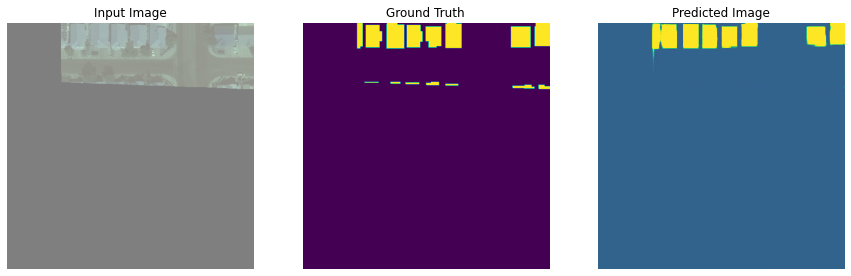

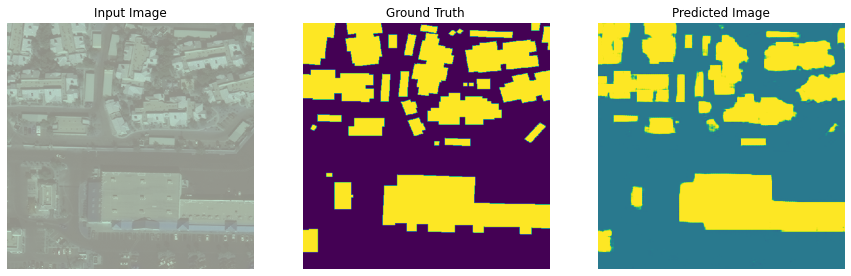

In [72]:
for inp2, tar2 in test_dataset.take(2):
  generate_images(generator, inp2, tar2)

In [73]:
generator_ex = generator(inp2,training=False)
disc_real_output_ex = discriminator([inp2, tar2], training=False)
disc_generated_output_ex = discriminator([inp2, generator_ex], training=False)

In [76]:
np.histogram(generator_ex[0])

(array([    19,    103,    783, 165252,   3943,   1378,   1106,    958,
          1171,  87431]),
 array([-0.6271008 , -0.46439075, -0.30168065, -0.13897058,  0.02373951,
         0.18644959,  0.34915966,  0.5118697 ,  0.67457986,  0.8372899 ,
         1.        ], dtype=float32))

(-0.5, 511.5, 511.5, -0.5)

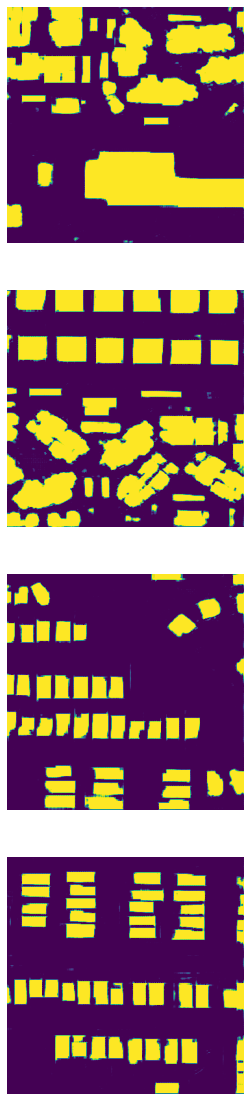

In [77]:
idxx = 0
fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(generator_ex[0],vmin=0, vmax=1)
axes[1].imshow(generator_ex[1],vmin=0, vmax=1)
axes[2].imshow(generator_ex[2],vmin=0, vmax=1)
axes[3].imshow(generator_ex[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

# plt.savefig('../random/pix2pixv1.png', bbox_inches='tight')

In [118]:
def my_tf_round(x, decimals = 0):
    multiplier = tf.constant(10**decimals, dtype=x.dtype)
    return tf.nn.relu(tf.round(x * multiplier) / multiplier)

In [135]:
metrics = tf.keras.metrics.MeanIoU(num_classes=2)
metrics_pre = tf.keras.metrics.Recall()
metrics_rec = tf.keras.metrics.Precision()


print("Calculating Validation")
sum_iou = []
sum_pre = []
sum_rec = []

for example_input, example_target in test_dataset.take(len(test_dataset)):
    prediction = generator(example_input, training=False )

    metrics.update_state(example_target,my_tf_round(prediction) , sample_weight=None)
    sum_iou.append(metrics.result().numpy())
    metrics.reset_states()
    
    
    metrics_pre.update_state(example_target,my_tf_round(prediction), sample_weight=None)
    sum_pre.append(metrics_pre.result().numpy())
    metrics_pre.reset_states()
    
    
    metrics_rec.update_state(example_target,my_tf_round(prediction), sample_weight=None)
    sum_rec.append(metrics_rec.result().numpy())
    metrics_rec.reset_states()

iou_average = np.average(sum_iou)
rec_average = np.average(sum_rec)
pre_average = np.average(sum_pre)

print(iou_average)
print(rec_average)
print(pre_average)

Calculating Validation
0.8761718
0.8907013
0.89387065


In [125]:
f1_score = rec_average * pre_average *2 / (rec_average + pre_average)
print(f1_score)

0.8922830975985824


# UNET COMP

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import Sequence , get_file
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler ,EarlyStopping
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf


import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, json, shutil
import os
import json
import sys
from datetime import datetime
import os
import time
from itertools import islice

import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


In [44]:
model_path = "/glade/scratch/hgamarro/Deep_learning/Final_Project/models/scratch/BD_v1_results_main/"

BACKBONE = 'vgg16'
# BACKBONE = 'resnet50'
# BACKBONE = 'efficientnetb6'
model_name = 'Unet'
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 100

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model


if model_name == 'Unet':
    print(model_name)
    model = sm.Unet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'Linknet':
    print(model_name)
    model = sm.Linknet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'FPN':
    print(model_name)
    model = sm.FPN(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
    

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5), sm.metrics.FScore(threshold=0.5)  ]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)


model.load_weights(model_path + "vgg16_Unet.h5")



Unet


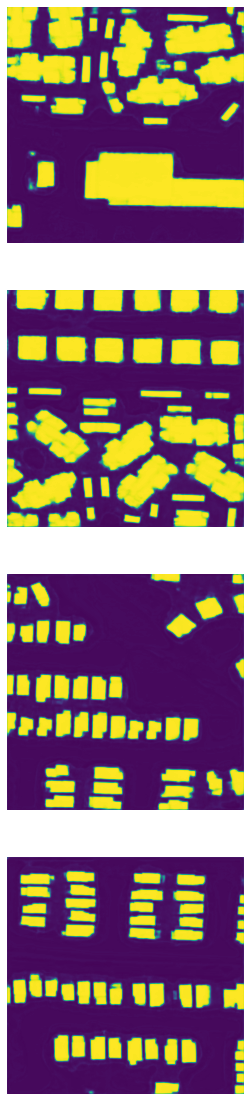

In [49]:
generator_ex = model.predict(inp2.numpy())

fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(generator_ex[0],vmin=0, vmax=1)
axes[1].imshow(generator_ex[1],vmin=0, vmax=1)
axes[2].imshow(generator_ex[2],vmin=0, vmax=1)
axes[3].imshow(generator_ex[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')

plt.savefig('../random/vgg16_Unet.png', bbox_inches='tight')

In [50]:
tf.keras.backend.clear_session()

BACKBONE = 'vgg16'
# BACKBONE = 'resnet50'
# BACKBONE = 'efficientnetb6'
# model_name = 'Unet'
model_name = 'Linknet'

BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 100

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model


if model_name == 'Unet':
    print(model_name)
    model = sm.Unet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'Linknet':
    print(model_name)
    model = sm.Linknet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'FPN':
    print(model_name)
    model = sm.FPN(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
    

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5), sm.metrics.FScore(threshold=0.5)  ]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)
model.load_weights(model_path + "vgg16_Linknet.h5")

Linknet


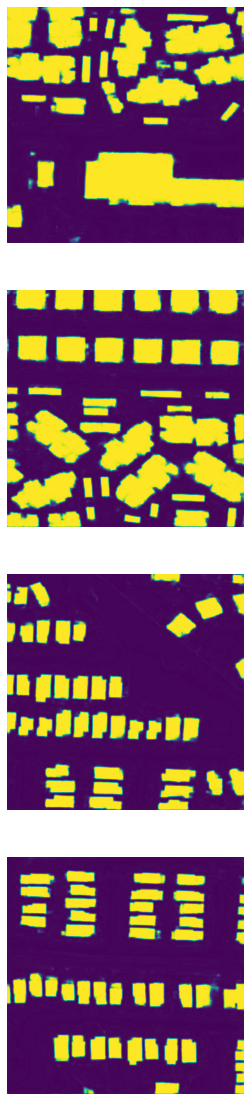

In [52]:
generator_ex = model.predict(inp2.numpy())

fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(generator_ex[0],vmin=0, vmax=1)
axes[1].imshow(generator_ex[1],vmin=0, vmax=1)
axes[2].imshow(generator_ex[2],vmin=0, vmax=1)
axes[3].imshow(generator_ex[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
plt.savefig('../random/vgg16_Linknet.png', bbox_inches='tight')

In [53]:
tf.keras.backend.clear_session()
BACKBONE = 'vgg16'
# BACKBONE = 'resnet50'
# BACKBONE = 'efficientnetb6'
model_name = 'FPN'
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 100

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model


if model_name == 'Unet':
    print(model_name)
    model = sm.Unet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'Linknet':
    print(model_name)
    model = sm.Linknet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'FPN':
    print(model_name)
    model = sm.FPN(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
    

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5), sm.metrics.FScore(threshold=0.5)  ]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)
model.load_weights(model_path + "vgg16_FPN.h5")

FPN


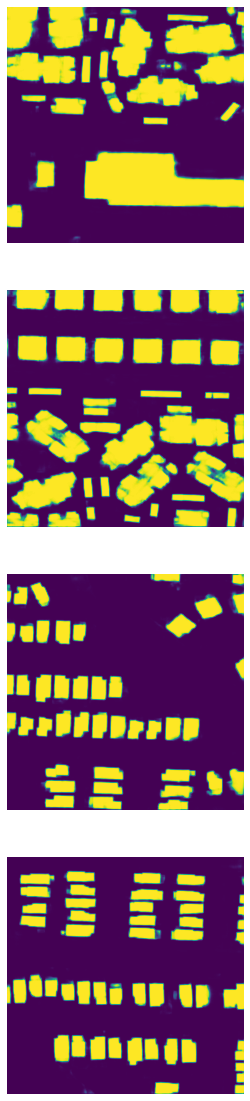

In [54]:
generator_ex = model.predict(inp2.numpy())

fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(generator_ex[0],vmin=0, vmax=1)
axes[1].imshow(generator_ex[1],vmin=0, vmax=1)
axes[2].imshow(generator_ex[2],vmin=0, vmax=1)
axes[3].imshow(generator_ex[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
plt.savefig('../random/vgg16_FPN.png', bbox_inches='tight')

In [ ]:
tf.keras.backend.clear_session()
# BACKBONE = 'vgg16'
# BACKBONE = 'resnet50'
BACKBONE = 'efficientnetb3'
model_name = 'Unet'
BATCH_SIZE = 32
LR = 0.0001
EPOCHS = 100

n_classes = 1  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model


if model_name == 'Unet':
    print(model_name)
    model = sm.Unet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'Linknet':
    print(model_name)
    model = sm.Linknet(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
elif model_name == 'FPN':
    print(model_name)
    model = sm.FPN(BACKBONE,classes=n_classes,input_shape=(512, 512, 3), activation=activation)
    

# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.Precision(threshold=0.5), sm.metrics.Recall(threshold=0.5), sm.metrics.FScore(threshold=0.5)  ]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)
model.load_weights(model_path + "efficientnetb3_Unet.h5")

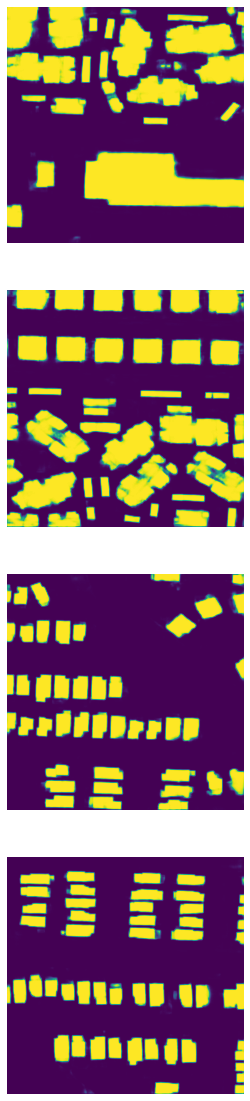

In [55]:
generator_ex = model.predict(inp2.numpy())

fig, axes = plt.subplots(4, 1, figsize=(20, 20))

# fig.subplots_adjust(hspace=0.1)


axes[0].imshow(generator_ex[0],vmin=0, vmax=1)
axes[1].imshow(generator_ex[1],vmin=0, vmax=1)
axes[2].imshow(generator_ex[2],vmin=0, vmax=1)
axes[3].imshow(generator_ex[3],vmin=0, vmax=1)

axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[3].axis('off')
plt.savefig('../random/efficientnetb3_Unet.png', bbox_inches='tight')